In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
################################################################################
# ABYSSAL-STYLE ΔΔG PREDICTOR - TRAINING & EVALUATION
################################################################################
"""
This notebook implements the training and evaluation pipeline for an ABYSSAL-style
protein stability change (ΔΔG) predictor.

PREREQUISITES:
- ESM2 embeddings already extracted and cached (see previous notebook)
- HDF5 files containing wt_embeddings, mut_embeddings, ddg_values

ARCHITECTURE OVERVIEW:
1. Light Attention Block: Learns to focus on relevant embedding features
2. Siamese Network: Processes WT and mutant embeddings with shared weights
3. Regression Head: Predicts ΔΔG from concatenated representations

DESIGN RATIONALE (following ABYSSAL paper):
- Light attention provides interpretable feature weighting without heavy parameters
- Siamese architecture ensures WT/mutant are processed identically (antisymmetry)
- Simple MLP head is sufficient when embeddings already capture structural info
"""

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import h5py
from pathlib import Path
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, spearmanr
from dataclasses import dataclass
from typing import Tuple, Dict, List
import json
import warnings
warnings.filterwarnings('ignore')

# Fix for PyTorch 2.6+ weights_only default change in A100 Colab environment
import torch.serialization
torch.serialization.add_safe_globals([np.ndarray, np.dtype, np.core.multiarray.scalar])

# Set style for publication-quality plots
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 100
plt.rcParams['font.size'] = 11

# Check device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if device.type == 'cuda':
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

    # Enable TF32 for A100 (faster matmul operations)
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True
    torch.backends.cudnn.benchmark = True  # A100 optimization

# Set random seeds for reproducibility
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.backends.cudnn.deterministic = False
    torch.backends.cudnn.benchmark = True

print(f"✓ Random seed set to {SEED}")

Using device: cuda
GPU: NVIDIA A100-SXM4-40GB
Memory: 42.47 GB
✓ Random seed set to 42


In [ ]:
################################################################################
# LOAD CACHED EMBEDDINGS
################################################################################
"""
Load the pre-computed ESM2 embeddings from the previous notebook.
These embeddings are position-specific representations at the mutation site.
"""

# Configure paths (adjust if needed)
DATA_DIR = Path("/content/drive/MyDrive/Protein_prediction_model/abyssal_embeddings/35M_embeddings")

# Check if embeddings exist
required_files = ['train_embeddings.h5', 'val_embeddings.h5', 'test_embeddings.h5']
missing_files = [f for f in required_files if not (DATA_DIR / f).exists()]

if missing_files:
    print("ERROR: Missing embedding files:")
    for f in missing_files:
        print(f"  - {f}")
    print("\nPlease run the embedding extraction notebook first.")
    raise FileNotFoundError("Required embedding files not found")

print("✓ All embedding files found")

# Quick inspection
for split in ['train', 'val', 'test']:
    h5_path = DATA_DIR / f"{split}_embeddings.h5"
    with h5py.File(h5_path, 'r') as h5f:
        n_samples = h5f['wt_embeddings'].shape[0]
        emb_dim = h5f['wt_embeddings'].shape[1]
        ddg_mean = np.mean(h5f['ddg_values'][:])
        ddg_std = np.std(h5f['ddg_values'][:])
    print(f"{split:5s}: {n_samples:4d} samples, dim={emb_dim}, "
          f"ΔΔG={ddg_mean:+.2f}±{ddg_std:.2f} kcal/mol")

✓ All embedding files found
train: 277012 samples, dim=480, ΔΔG=+0.75±0.99 kcal/mol
val  : 58883 samples, dim=480, ΔΔG=+0.98±1.14 kcal/mol
test : 39665 samples, dim=480, ΔΔG=+0.74±0.98 kcal/mol


In [ ]:
################################################################################
# PYTORCH DATASET CLASS
################################################################################
"""
Lazy-loading dataset for cached embeddings.
Loads data on-the-fly to minimize memory usage.
"""

class MutationEmbeddingDataset(Dataset):
    """
    PyTorch Dataset for mutation embeddings stored in HDF5.

    Returns:
        wt_embedding: (1280,) tensor - Wild-type embedding at mutation position
        mut_embedding: (1280,) tensor - Mutant embedding at mutation position
        ddg: scalar tensor - Experimental ΔΔG value (kcal/mol)
    """

    def __init__(self, split: str, data_dir: Path):
        self.split = split
        self.h5_path = data_dir / f"{split}_embeddings.h5"

        with h5py.File(self.h5_path, 'r') as h5f:
            self.n_samples = h5f['wt_embeddings'].shape[0]
            self.embedding_dim = h5f['wt_embeddings'].shape[1]

    def __len__(self) -> int:
        return self.n_samples

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        if not hasattr(self, 'h5f'):
            self.h5f = h5py.File(self.h5_path, 'r')

        wt_emb = torch.from_numpy(self.h5f['wt_embeddings'][idx]).float()
        mut_emb = torch.from_numpy(self.h5f['mut_embeddings'][idx]).float()
        ddg = torch.tensor(self.h5f['ddg_values'][idx]).float()

        return wt_emb, mut_emb, ddg

# Create datasets
train_dataset = MutationEmbeddingDataset('train', DATA_DIR)
val_dataset = MutationEmbeddingDataset('val', DATA_DIR)
test_dataset = MutationEmbeddingDataset('test', DATA_DIR)

print(f"\n✓ Datasets loaded:")
print(f"  Train: {len(train_dataset)} samples")
print(f"  Val:   {len(val_dataset)} samples")
print(f"  Test:  {len(test_dataset)} samples")


✓ Datasets loaded:
  Train: 277012 samples
  Val:   58883 samples
  Test:  39665 samples


In [ ]:
################################################################################
# STEP 3: LIGHT ATTENTION BLOCK
################################################################################
"""
Light Attention mechanism from the ABYSSAL paper.

DESIGN RATIONALE:
- Uses 1D convolution to capture local patterns in embedding space
- Two parallel paths:
  1. Feature path: Extracts relevant patterns
  2. Attention path: Learns importance weights (via softmax)
- Element-wise multiplication (Hadamard product) applies attention
- Global average pooling aggregates attended features

WHY THIS WORKS:
- ESM2 embeddings are n-dimensional feature vectors
- Not all dimensions are equally relevant for stability prediction
- Attention learns which features matter most for ΔΔG
- Lightweight: only ~30K parameters vs millions in full self-attention

INPUT:  (batch, 1, emb_dim) - unsqueezed embedding
OUTPUT: (batch, embdim) - attended and pooled features

Embedding dimensions:
- esm2_t33_650M_UR50D: 1280
- esm2_t30_150M_UR50D: 640
- esm2_t12_35M_UR50D: 480
- esm2_t6_8M_UR50D: 320
"""

class LightAttention(nn.Module):
    """
    Light Attention Block following ABYSSAL architecture.

    Uses parallel 1D convolutions to:
    1. Extract features from embeddings
    2. Generate attention weights
    3. Apply attention via element-wise multiplication

    Args:
        embedding_dim: Dimension of input embeddings
        kernel_size: Convolution kernel size (9 in ABYSSAL paper)

    Embedding dimensions:
    - esm2_t33_650M_UR50D: 1280
    - esm2_t30_150M_UR50D: 640
    - esm2_t12_35M_UR50D: 480
    - esm2_t6_8M_UR50D: 320
    """

    def __init__(self, embedding_dim: int = 480, kernel_size: int = 9): # CHANGE DIMENSION!!!
        super().__init__()

        self.embedding_dim = embedding_dim
        self.kernel_size = kernel_size

        # Calculate padding to maintain dimension: padding = (kernel_size - 1) // 2
        self.padding = (kernel_size - 1) // 2  # = 4 for kernel_size=9

        # Feature extraction path
        # Input: (batch, 1, dim) -> Output: (batch, 1, 2xdim)
        self.feature_conv = nn.Conv1d(
            in_channels=1,
            out_channels=1,
            kernel_size=kernel_size,
            padding=self.padding,
            bias=True
        )

        # Attention weight generation path
        # Input: (batch, 1, dim) -> Output: (batch, 1, 2xdim)
        self.attention_conv = nn.Conv1d(
            in_channels=1,
            out_channels=1,
            kernel_size=kernel_size,
            padding=self.padding,
            bias=True
        )

        # Initialize weights with small values for stable training
        nn.init.xavier_uniform_(self.feature_conv.weight, gain=0.5)
        nn.init.xavier_uniform_(self.attention_conv.weight, gain=0.5)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass through light attention.

        Args:
            x: Input tensor of shape (batch, 1, embedding_dim)
               Must be unsqueezed: original (batch, embedding_dim) -> (batch, 1, embedding_dim)

        Returns:
            attended: Output tensor of shape (batch, embedding_dim)
        """
        # Verify input shape
        assert x.dim() == 3, f"Expected 3D input (batch, 1, dim), got shape {x.shape}"
        assert x.size(1) == 1, f"Expected size 1 in dimension 1, got {x.size(1)}"
        assert x.size(2) == 480, f"Expected dim 480, got{x.size(2)}" # CHANGE DIMENSION!!!

        # Feature path: learn relevant patterns
        features = self.feature_conv(x)  # (batch, 1, embedding_dim)

        # Attention path: learn importance weights
        attention_logits = self.attention_conv(x)  # (batch, 1, embedding_dim)

        # Apply softmax to get normalized attention weights
        # Softmax along the embedding dimension (dim=2)
        attention_weights = torch.sigmoid(attention_logits)  # (batch, 1, embedding_dim)

        # Apply attention: element-wise multiplication (Hadamard product)
        attended = features * attention_weights  # (batch, 1, embedding_dim)

        # Global average pooling: reduce the channel dimension
        # Squeeze to remove the singleton dimension
        attended = attended.squeeze(1)  # (batch, embedding_dim)

        return attended

# Test Light Attention with dummy data
print("\n" + "="*60)
print("TESTING LIGHT ATTENTION BLOCK")
print("="*60)

# Create dummy batch
batch_size = 4
embedding_dim = 480 # CHANGE DIMENSION!!!

dummy_embeddings = torch.randn(batch_size, embedding_dim)
print(f"Input shape: {dummy_embeddings.shape}")

# Light attention expects (batch, 1, embedding_dim)
dummy_input = dummy_embeddings.unsqueeze(1)
print(f"Unsqueezed shape: {dummy_input.shape}")

# Initialize and test
light_attn = LightAttention(embedding_dim=embedding_dim, kernel_size=9)
light_attn = light_attn.to(device)  # A100 optimization
dummy_input = dummy_input.to(device)  # A100 optimization
output = light_attn(dummy_input)

print(f"Output shape: {output.shape}")
print(f"Expected shape: ({batch_size}, {embedding_dim})")

assert output.shape == (batch_size, embedding_dim), "Shape mismatch!"
print("✓ Light Attention test passed!")

# Check parameter count
n_params = sum(p.numel() for p in light_attn.parameters())
print(f"✓ Light Attention parameters: {n_params:,}")


TESTING LIGHT ATTENTION BLOCK
Input shape: torch.Size([4, 480])
Unsqueezed shape: torch.Size([4, 1, 480])
Output shape: torch.Size([4, 480])
Expected shape: (4, 480)
✓ Light Attention test passed!
✓ Light Attention parameters: 20


In [ ]:
################################################################################
# STEP 4: SIAMESE NETWORK ARCHITECTURE
################################################################################
"""
Siamese Network for ΔΔG prediction.

ARCHITECTURE RATIONALE:
1. SIAMESE DESIGN (shared weights for WT and mutant):
   - Ensures identical processing of both sequences
   - Promotes antisymmetry: ΔΔG(WT→Mut) ≈ -ΔΔG(Mut→WT)
   - Reduces parameters and overfitting

2. LIGHT ATTENTION:
   - Focuses on relevant embedding features
   - Provides interpretability via attention weights

3. CONCATENATION:
   - Preserves both WT and mutant information
   - Allows network to learn difference patterns
   - Alternative: could use subtraction, but concat is more expressive

4. MLP HEAD:
   - 2560 → 1024: Large capacity for complex patterns
   - 1024 → 256: Bottleneck forces abstraction
   - 256 → 1: Final regression output
   - ReLU: Non-linearity for complex decision boundaries
   - Dropout: Regularization to prevent overfitting

INPUT:
  wt_embedding: (batch, emb_dim)
  mut_embedding: (batch, emb_dim)

OUTPUT:
  ddg_pred: (batch,) - predicted ΔΔG values
"""

class SiameseDDGPredictor(nn.Module):
    """
    Siamese network with Light Attention for ΔΔG prediction.

    Processes wild-type and mutant embeddings through shared attention,
    then predicts stability change from their concatenation.
    """

    def __init__(
        self,
        embedding_dim: int = 480, # CHANGE DIMENSION!!!
        attention_kernel: int = 9,
        hidden_dims: List[int] = [512, 128], # CHANGE HIDDEN LAYERS!!!
        dropout_rate: float = 0.4
    ):
        super().__init__()

        self.embedding_dim = embedding_dim

        # Shared Light Attention block
        # This is the "Siamese" part - same weights for WT and mutant
        self.attention = LightAttention(
            embedding_dim=embedding_dim,
            kernel_size=attention_kernel
        )

        # Fully connected layers for regression
        # Input: concatenated [wt_attended, mut_attended] = 2x dims
        layers = []

        input_dim = embedding_dim * 2  # 2xemb_dim after concatenation

        for hidden_dim in hidden_dims:
            layers.extend([
                nn.Linear(input_dim, hidden_dim),
                nn.ReLU(),
                nn.Dropout(dropout_rate)
            ])
            input_dim = hidden_dim

        # Final regression layer (no activation - raw output)
        layers.append(nn.Linear(input_dim, 1))

        self.regressor = nn.Sequential(*layers)

        # Initialize weights for stable training
        self._initialize_weights()

    def _initialize_weights(self):
        """Initialize network weights using best practices."""
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def forward(
        self,
        wt_embedding: torch.Tensor,
        mut_embedding: torch.Tensor
    ) -> torch.Tensor:
        """
        Forward pass through Siamese network.

        Args:
            wt_embedding: (batch, emb_dim) - Wild-type embeddings
            mut_embedding: (batch, emb_dim) - Mutant embeddings

        Returns:
            ddg_pred: (batch,) - Predicted ΔΔG values
        """
        # Unsqueeze for Light Attention: (batch, emb_dim) -> (batch, 1, emb_dim)
        wt_input = wt_embedding.unsqueeze(1)
        mut_input = mut_embedding.unsqueeze(1)

        # Apply shared attention to both embeddings
        # This is where the "Siamese" property is enforced
        wt_attended = self.attention(wt_input)    # (batch, emb_dim)
        mut_attended = self.attention(mut_input)  # (batch, emb_dim)

        # Concatenate attended representations
        combined = torch.cat([wt_attended, mut_attended], dim=1)  # (batch, 2xemb_dim)

        # Predict ΔΔG through MLP
        ddg_pred = self.regressor(combined).squeeze(-1)  # (batch,)

        return ddg_pred

    def predict_antisymmetric(
        self,
        wt_embedding: torch.Tensor,
        mut_embedding: torch.Tensor
    ) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Predict both forward and reverse ΔΔG for antisymmetry check.

        Forward: ΔΔG(WT→Mut)
        Reverse: ΔΔG(Mut→WT) should ≈ -ΔΔG(Mut→WT)

        Returns:
            forward_ddg: ΔΔG(WT→Mut)
            reverse_ddg: ΔΔG(Mut→WT)
        """
        forward_ddg = self.forward(wt_embedding, mut_embedding)
        reverse_ddg = self.forward(mut_embedding, wt_embedding)
        return forward_ddg, reverse_ddg

# Test Siamese Network
print("\n" + "="*60)
print("TESTING SIAMESE NETWORK")
print("="*60)

# Create model
model = SiameseDDGPredictor(
    embedding_dim=480, # CHANGE DIMENSION!!!
    attention_kernel=9,
    hidden_dims=[512, 128], #CHANGE HIDDEN LAYERS!!!
    dropout_rate=0.3
).to(device)

# Dummy forward pass
batch_size = 4
dummy_wt = torch.randn(batch_size, 480).to(device) # CHANGE DIMENSION!!!
dummy_mut = torch.randn(batch_size, 480).to(device) # CHANGE DIMENSION!!!

print(f"Input shapes:")
print(f"  WT:  {dummy_wt.shape}")
print(f"  Mut: {dummy_mut.shape}")

# Forward prediction
model.eval()  # A100 optimization
with torch.no_grad():  # A100 optimization
    ddg_pred = model(dummy_wt, dummy_mut)
print(f"Output shape: {ddg_pred.shape}")
print(f"Sample predictions: {ddg_pred[:3].detach().cpu().numpy()}")

# Test antisymmetric prediction
with torch.no_grad():  # A100 optimization
    forward_ddg, reverse_ddg = model.predict_antisymmetric(dummy_wt, dummy_mut)
print(f"\nAntisymmetry test:")
print(f"  Forward ΔΔG: {forward_ddg[:3].detach().cpu().numpy()}")
print(f"  Reverse ΔΔG: {reverse_ddg[:3].detach().cpu().numpy()}")
print(f"  Sum (should be ≈0): {(forward_ddg + reverse_ddg)[:3].detach().cpu().numpy()}")

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\n✓ Model initialized successfully")
print(f"✓ Total parameters: {total_params:,}")
print(f"✓ Trainable parameters: {trainable_params:,}")


TESTING SIAMESE NETWORK
Input shapes:
  WT:  torch.Size([4, 480])
  Mut: torch.Size([4, 480])
Output shape: torch.Size([4])
Sample predictions: [0.8398272  0.71693534 1.0847661 ]

Antisymmetry test:
  Forward ΔΔG: [0.8398272  0.71693534 1.0847661 ]
  Reverse ΔΔG: [1.0964848  0.41916096 0.7021049 ]
  Sum (should be ≈0): [1.936312  1.1360962 1.7868711]

✓ Model initialized successfully
✓ Total parameters: 557,845
✓ Trainable parameters: 557,845


In [ ]:
################################################################################
# STEP 5: TRAINING CONFIGURATION AND UTILITIES
################################################################################
"""
Training setup and utilities.

KEY DESIGN CHOICES:
1. MSE Loss: Standard for regression, penalizes large errors quadratically
2. Adam optimizer: Adaptive learning rates, works well with sparse gradients
3. Two-phase learning:
   - Phase 1 (lr=1e-4): Fast initial learning
   - Phase 2 (lr=1e-5): Fine-tuning for convergence
4. Gradient clipping: Prevents exploding gradients
5. Early stopping on Pearson correlation: Proper metric for regression quality
"""

@dataclass
class TrainingConfig:
    """Training hyperparameters."""
    # Learning rates
    lr_phase1: float = 3e-4  # Initial learning rate
    lr_phase2: float = 1e-5  # Fine-tuning learning rate

    # Training epochs
    epochs_phase1: int = 30  # Initial training epochs
    epochs_phase2: int = 20  # Fine-tuning epochs

    # Batch sizes
    batch_size: int = 128

    # Regularization
    weight_decay: float = 1e-4
    gradient_clip: float = 1.0  # Gradient clipping threshold

    # Early stopping
    patience_phase1: int = 8  # Stop if no improvement for N epochs
    patience_phase2: int = 5  # Stop if no improvement for N epochs
    min_delta: float = 0.002  # Minimum improvement threshold

    # Model saving
    save_dir: Path = Path("/content/drive/MyDrive/Protein_prediction_model/Saved_model")

    # Device
    device: torch.device = device

config = TrainingConfig()
config.save_dir.mkdir(exist_ok=True)

print("Training Configuration:")
print(f"  Phase 1: {config.epochs_phase1} epochs @ lr={config.lr_phase1}")
print(f"  Phase 2: {config.epochs_phase2} epochs @ lr={config.lr_phase2}")
print(f"  Batch size: {config.batch_size}")
print(f"  Early stopping patience for phase 1: {config.patience_phase1}")
print(f"  Early stopping patience for phase 2: {config.patience_phase2}")
print(f"  Gradient clipping: {config.gradient_clip}")

Training Configuration:
  Phase 1: 30 epochs @ lr=0.0003
  Phase 2: 20 epochs @ lr=1e-05
  Batch size: 128
  Early stopping patience for phase 1: 8
  Early stopping patience for phase 2: 5
  Gradient clipping: 1.0


In [ ]:
################################################################################
# TRAINING UTILITIES
################################################################################

class EarlyStopping:
    """
    Early stopping based on validation Pearson correlation.

    WHY PEARSON CORRELATION:
    - MSE loss can be misleading (scale-dependent)
    - Pearson measures linear relationship quality
    - Standard metric in protein stability literature
    - Higher correlation = better predictions
    """

    def __init__(self, patience: int = 10, min_delta: float = 0.001):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_score = -np.inf
        self.early_stop = False
        self.best_epoch = 0

    def __call__(self, score: float, epoch: int) -> bool:
        """
        Check if training should stop.

        Args:
            score: Current validation Pearson correlation
            epoch: Current epoch number

        Returns:
            True if should stop, False otherwise
        """
        if score > self.best_score + self.min_delta:
            self.best_score = score
            self.counter = 0
            self.best_epoch = epoch
            return False
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
                return True
            return False

def compute_metrics(y_true: np.ndarray, y_pred: np.ndarray) -> Dict[str, float]:
    """
    Compute all evaluation metrics for ΔΔG prediction.

    Metrics:
    - Pearson correlation (PCC): Linear relationship strength
    - Spearman correlation (SCC): Monotonic relationship (rank-based)
    - RMSE: Root mean squared error (kcal/mol)
    - MAE: Mean absolute error (kcal/mol)
    - Accuracy: Correct sign prediction (stabilizing vs destabilizing)

    Returns:
        Dictionary of metric name -> value
    """
    # Correlations
    pcc, pcc_pval = pearsonr(y_true, y_pred)
    scc, scc_pval = spearmanr(y_true, y_pred)

    # Error metrics
    rmse = np.sqrt(np.mean((y_true - y_pred) ** 2))
    mae = np.mean(np.abs(y_true - y_pred))

    # Sign accuracy (stabilizing: ΔΔG < 0, destabilizing: ΔΔG ≥ 0)
    true_signs = (y_true < 0).astype(int)
    pred_signs = (y_pred < 0).astype(int)
    accuracy = np.mean(true_signs == pred_signs)

    return {
        'pearson': pcc,
        'pearson_pval': pcc_pval,
        'spearman': scc,
        'spearman_pval': scc_pval,
        'rmse': rmse,
        'mae': mae,
        'accuracy': accuracy
    }

def train_epoch(
    model: nn.Module,
    dataloader: DataLoader,
    optimizer: torch.optim.Optimizer,
    criterion: nn.Module,
    device: torch.device,
    gradient_clip: float = 1.0,
    scaler: torch.cuda.amp.GradScaler = None  # A100 mixed precision support
) -> Tuple[float, Dict[str, float]]:
    """
    Train for one epoch.

    Returns:
        avg_loss: Average loss over epoch
        metrics: Training metrics
    """
    model.train()
    total_loss = 0
    all_preds = []
    all_targets = []

    pbar = tqdm(dataloader, desc="Training", leave=False)
    for wt_emb, mut_emb, ddg in pbar:
        wt_emb = wt_emb.to(device, non_blocking=True)  # A100 optimization
        mut_emb = mut_emb.to(device, non_blocking=True)  # A100 optimization
        ddg = ddg.to(device, non_blocking=True)  # A100 optimization

        optimizer.zero_grad(set_to_none=True)  # A100 optimization

        # Use autocast for A100 mixed precision
        with torch.cuda.amp.autocast():
            pred_ddg = model(wt_emb, mut_emb)
            loss = criterion(pred_ddg, ddg)

        # Backward pass with gradient scaling for A100
        if scaler is not None:
            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), gradient_clip)
            scaler.step(optimizer)
            scaler.update()
        else:
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), gradient_clip)
            optimizer.step()

        # Track metrics
        total_loss += loss.item()
        all_preds.extend(pred_ddg.detach().cpu().numpy())
        all_targets.extend(ddg.cpu().numpy())

        pbar.set_postfix({'loss': loss.item()})

    avg_loss = total_loss / len(dataloader)
    metrics = compute_metrics(np.array(all_targets), np.array(all_preds))

    return avg_loss, metrics

@torch.no_grad()
def evaluate(
    model: nn.Module,
    dataloader: DataLoader,
    criterion: nn.Module,
    device: torch.device
) -> Tuple[float, Dict[str, float]]:
    """
    Evaluate model on validation/test set.

    Returns:
        avg_loss: Average loss
        metrics: Evaluation metrics
    """
    model.eval()
    total_loss = 0
    all_preds = []
    all_targets = []

    for wt_emb, mut_emb, ddg in tqdm(dataloader, desc="Evaluating", leave=False):
        wt_emb = wt_emb.to(device, non_blocking=True)  # A100 optimization
        mut_emb = mut_emb.to(device, non_blocking=True)  # A100 optimization
        ddg = ddg.to(device, non_blocking=True)  # A100 optimization


        with torch.cuda.amp.autocast():  # A100 optimization
            pred_ddg = model(wt_emb, mut_emb)
            loss = criterion(pred_ddg, ddg)

        total_loss += loss.item()
        all_preds.extend(pred_ddg.cpu().numpy())
        all_targets.extend(ddg.cpu().numpy())

    avg_loss = total_loss / len(dataloader)
    metrics = compute_metrics(np.array(all_targets), np.array(all_preds))

    return avg_loss, metrics

print("✓ Training utilities defined")

✓ Training utilities defined


In [ ]:
################################################################################
# STEP 6: MAIN TRAINING LOOP
################################################################################
"""
Two-phase training strategy:

PHASE 1 (lr=1e-4, 50 epochs):
- Fast learning to find good parameter region
- Model learns basic patterns

PHASE 2 (lr=1e-5, 30 epochs):
- Fine-tuning with smaller steps
- Converges to local optimum
- Starts from Phase 1 best checkpoint
"""

def train_model(
    model: nn.Module,
    train_loader: DataLoader,
    val_loader: DataLoader,
    config: TrainingConfig
) -> Dict:
    """
    Full training pipeline with two learning rate phases.

    Returns:
        history: Training history with losses and metrics
    """
    # Loss function (Huberloss for regression)
    criterion = nn.SmoothL1Loss(beta=1.0)

    # Mixed precision scaler for A100
    scaler = torch.cuda.amp.GradScaler() if config.device.type == 'cuda' else None

    # Training history
    history = {
        'train_loss': [],
        'val_loss': [],
        'train_pearson': [],
        'val_pearson': [],
        'train_mae': [],
        'val_mae': [],
        'best_epoch': 0,
        'best_val_pearson': -np.inf,
        'phase1_early_stop_epoch': 0,
        'phase2_early_stop_epoch': 0
    }

    print("\n" + "="*60)
    print("TRAINING STARTED")
    print("="*60)

    # ========================================================================
    # PHASE 1: Initial Training
    # ========================================================================
    print(f"\nPHASE 1: lr={config.lr_phase1}, epochs={config.epochs_phase1}")
    print("-" * 60)

    optimizer = torch.optim.Adam(
        model.parameters(),
        lr=config.lr_phase1,
        weight_decay=config.weight_decay
    )

    early_stopping = EarlyStopping(
        patience=config.patience_phase1,
        min_delta=config.min_delta
    )

    for epoch in range(config.epochs_phase1):
        # Train
        train_loss, train_metrics = train_epoch(
            model, train_loader, optimizer, criterion, config.device, config.gradient_clip, scaler
        )

        # Validate
        val_loss, val_metrics = evaluate(
            model, val_loader, criterion, config.device
        )

        # Record history
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_pearson'].append(train_metrics['pearson'])
        history['val_pearson'].append(val_metrics['pearson'])
        history['train_mae'].append(train_metrics['mae'])
        history['val_mae'].append(val_metrics['mae'])

        # Print progress
        print(f"Epoch {epoch+1:3d}/{config.epochs_phase1}: "
              f"train_loss={train_loss:.4f}, val_loss={val_loss:.4f}, "
              f"train_PCC={train_metrics['pearson']:.3f}, "
              f"val_PCC={val_metrics['pearson']:.3f}")

        # Save best model
        if val_metrics['pearson'] > history['best_val_pearson']:
            history['best_val_pearson'] = val_metrics['pearson']
            history['best_epoch'] = epoch + 1
            best_model ={'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_pearson': val_metrics['pearson'],
                'config': config}
            torch.save(best_model, config.save_dir / 'best_model_phase1.pt')
            print(f"  → Saved best model (val_PCC={val_metrics['pearson']:.3f})")

        # Early stopping check
        if early_stopping(val_metrics['pearson'], epoch):
            history['phase1_early_stop_epoch'] = epoch+1
            print(f"\nEarly stopping triggered at epoch {epoch+1}")
            print(f"Best validation PCC: {early_stopping.best_score:.3f} at epoch {early_stopping.best_epoch+1}")
            break

    # ========================================================================
    # PHASE 2: Fine-tuning
    # ========================================================================
    print(f"\nPHASE 2: Fine-tuning with lr={config.lr_phase2}")
    print("-" * 60)
    # Load best model from Phase 1
    checkpoint = torch.load(config.save_dir / 'best_model_phase1.pt', weights_only=False)
    model.load_state_dict(checkpoint['model_state_dict'])
    print(f"Loaded Phase 1 best model (val_PCC={checkpoint['val_pearson']:.3f})")

    # New optimizer with lower learning rate
    optimizer = torch.optim.Adam(
        model.parameters(),
        lr=config.lr_phase2,
        weight_decay=config.weight_decay
    )

    # Reset early stopping for Phase 2
    early_stopping = EarlyStopping(
        patience=config.patience_phase2,
        min_delta=config.min_delta
    )

    phase2_start_epoch = len(history['train_loss'])

    for epoch in range(config.epochs_phase2):
        # Train
        train_loss, train_metrics = train_epoch(
            model, train_loader, optimizer, criterion, config.device, config.gradient_clip, scaler
        )

        # Validate
        val_loss, val_metrics = evaluate(
            model, val_loader, criterion, config.device
        )

        # Record history
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_pearson'].append(train_metrics['pearson'])
        history['val_pearson'].append(val_metrics['pearson'])
        history['train_mae'].append(train_metrics['mae'])
        history['val_mae'].append(val_metrics['mae'])

        # Print progress
        print(f"Epoch {epoch+1:3d}/{config.epochs_phase2}: "
            f"train_loss={train_loss:.4f}, val_loss={val_loss:.4f}, "
            f"train_PCC={train_metrics['pearson']:.3f}, "
            f"val_PCC={val_metrics['pearson']:.3f}")

        # Save best model
        if val_metrics['pearson'] > history['best_val_pearson']:
            history['best_val_pearson'] = val_metrics['pearson']
            history['best_epoch'] = phase2_start_epoch + epoch + 1
            best_model ={'epoch': phase2_start_epoch + epoch,
                         'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_pearson': val_metrics['pearson'],
                'config': config
            }
            print(f"  → Best model (val_PCC={val_metrics['pearson']:.3f})")

        else:
            print(f"  → No improvement (val_PCC={val_metrics['pearson']:.3f})")

        torch.save(best_model, config.save_dir / 'best_model_final.pt')
        print(f"  → Saved final model (val_PCC={val_metrics['pearson']:.3f})")

        # Early stopping check
        if early_stopping(val_metrics['pearson'], epoch):
            history['phase2_early_stop_epoch'] = epoch+1
            print(f"\nEarly stopping triggered at epoch {epoch+1}")
            print(f"Best validation PCC: {early_stopping.best_score:.3f}")
            break

    print("\n" + "="*60)
    print("TRAINING COMPLETED")
    print("="*60)
    print(f"Best validation Pearson: {history['best_val_pearson']:.3f}")
    print(f"Best epoch: {history['best_epoch']}")

    return history

In [ ]:
# Create data loaders
train_loader = DataLoader(
    train_dataset,
    batch_size=config.batch_size,
    shuffle=True,
    num_workers=2,  # A100 benefits from parallel data loading
    pin_memory=True, # A100 GPU memory optimization
    persistent_workers=True # Reduce worker recreation overhead on A100
    )

val_loader = DataLoader(
    val_dataset,
    batch_size=config.batch_size,
    shuffle=False,
    num_workers=2,  # A100 benefits from parallel data loading
    pin_memory=True, # A100 GPU memory optimization
    persistent_workers=True # Reduce worker recreation overhead on A100
    )

# Initialize model
model = SiameseDDGPredictor(
    embedding_dim=480, # CHANGE DIMENSION!!!
    attention_kernel=9,
    hidden_dims=[512, 128], # CHANGE HIDDEN LAYERS!!!
    dropout_rate=0.3
    ).to(config.device)
# Train model

history = train_model(model, train_loader, val_loader, config)


TRAINING STARTED

PHASE 1: lr=0.0003, epochs=30
------------------------------------------------------------


Training:   0%|          | 0/2165 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/461 [00:00<?, ?it/s]

Epoch   1/30: train_loss=0.2613, val_loss=0.3442, train_PCC=0.609, val_PCC=0.615
  → Saved best model (val_PCC=0.615)


Training:   0%|          | 0/2165 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/461 [00:00<?, ?it/s]

Epoch   2/30: train_loss=0.1957, val_loss=0.3384, train_PCC=0.739, val_PCC=0.623
  → Saved best model (val_PCC=0.623)


Training:   0%|          | 0/2165 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/461 [00:00<?, ?it/s]

Epoch   3/30: train_loss=0.1702, val_loss=0.3478, train_PCC=0.782, val_PCC=0.618


Training:   0%|          | 0/2165 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/461 [00:00<?, ?it/s]

Epoch   4/30: train_loss=0.1543, val_loss=0.3536, train_PCC=0.807, val_PCC=0.604


Training:   0%|          | 0/2165 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/461 [00:00<?, ?it/s]

Epoch   5/30: train_loss=0.1451, val_loss=0.3523, train_PCC=0.821, val_PCC=0.612


Training:   0%|          | 0/2165 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/461 [00:00<?, ?it/s]

Epoch   6/30: train_loss=0.1379, val_loss=0.3527, train_PCC=0.832, val_PCC=0.620


Training:   0%|          | 0/2165 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/461 [00:00<?, ?it/s]

Epoch   7/30: train_loss=0.1327, val_loss=0.3469, train_PCC=0.839, val_PCC=0.626
  → Saved best model (val_PCC=0.626)


Training:   0%|          | 0/2165 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/461 [00:00<?, ?it/s]

Epoch   8/30: train_loss=0.1285, val_loss=0.3463, train_PCC=0.846, val_PCC=0.624


Training:   0%|          | 0/2165 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/461 [00:00<?, ?it/s]

Epoch   9/30: train_loss=0.1255, val_loss=0.3452, train_PCC=0.850, val_PCC=0.629
  → Saved best model (val_PCC=0.629)


Training:   0%|          | 0/2165 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e482e90b060>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e482e90b060>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Evaluating:   0%|          | 0/461 [00:00<?, ?it/s]

Epoch  10/30: train_loss=0.1232, val_loss=0.3434, train_PCC=0.853, val_PCC=0.635
  → Saved best model (val_PCC=0.635)


Training:   0%|          | 0/2165 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e482e90b060>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e482e90b060>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Evaluating:   0%|          | 0/461 [00:00<?, ?it/s]

Epoch  11/30: train_loss=0.1208, val_loss=0.3408, train_PCC=0.856, val_PCC=0.637
  → Saved best model (val_PCC=0.637)


Training:   0%|          | 0/2165 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/461 [00:00<?, ?it/s]

Epoch  12/30: train_loss=0.1185, val_loss=0.3476, train_PCC=0.859, val_PCC=0.633


Training:   0%|          | 0/2165 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/461 [00:00<?, ?it/s]

Epoch  13/30: train_loss=0.1172, val_loss=0.3494, train_PCC=0.861, val_PCC=0.629


Training:   0%|          | 0/2165 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/461 [00:00<?, ?it/s]

Epoch  14/30: train_loss=0.1154, val_loss=0.3412, train_PCC=0.864, val_PCC=0.631


Training:   0%|          | 0/2165 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/461 [00:00<?, ?it/s]

Epoch  15/30: train_loss=0.1139, val_loss=0.3398, train_PCC=0.866, val_PCC=0.634


Training:   0%|          | 0/2165 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/461 [00:00<?, ?it/s]

Epoch  16/30: train_loss=0.1134, val_loss=0.3389, train_PCC=0.866, val_PCC=0.642
  → Saved best model (val_PCC=0.642)


Training:   0%|          | 0/2165 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/461 [00:00<?, ?it/s]

Epoch  17/30: train_loss=0.1124, val_loss=0.3412, train_PCC=0.868, val_PCC=0.640


Training:   0%|          | 0/2165 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/461 [00:00<?, ?it/s]

Epoch  18/30: train_loss=0.1115, val_loss=0.3462, train_PCC=0.869, val_PCC=0.630


Training:   0%|          | 0/2165 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/461 [00:00<?, ?it/s]

Epoch  19/30: train_loss=0.1104, val_loss=0.3357, train_PCC=0.871, val_PCC=0.646
  → Saved best model (val_PCC=0.646)


Training:   0%|          | 0/2165 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/461 [00:00<?, ?it/s]

Epoch  20/30: train_loss=0.1100, val_loss=0.3364, train_PCC=0.871, val_PCC=0.643


Training:   0%|          | 0/2165 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/461 [00:00<?, ?it/s]

Epoch  21/30: train_loss=0.1091, val_loss=0.3387, train_PCC=0.872, val_PCC=0.638


Training:   0%|          | 0/2165 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/461 [00:00<?, ?it/s]

Epoch  22/30: train_loss=0.1081, val_loss=0.3428, train_PCC=0.874, val_PCC=0.640


Training:   0%|          | 0/2165 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/461 [00:00<?, ?it/s]

Epoch  23/30: train_loss=0.1078, val_loss=0.3412, train_PCC=0.874, val_PCC=0.639


Training:   0%|          | 0/2165 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/461 [00:00<?, ?it/s]

Epoch  24/30: train_loss=0.1071, val_loss=0.3404, train_PCC=0.875, val_PCC=0.637


Training:   0%|          | 0/2165 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/461 [00:00<?, ?it/s]

Epoch  25/30: train_loss=0.1071, val_loss=0.3370, train_PCC=0.875, val_PCC=0.645


Training:   0%|          | 0/2165 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/461 [00:00<?, ?it/s]

Epoch  26/30: train_loss=0.1060, val_loss=0.3299, train_PCC=0.877, val_PCC=0.645


Training:   0%|          | 0/2165 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/461 [00:00<?, ?it/s]

Epoch  27/30: train_loss=0.1059, val_loss=0.3403, train_PCC=0.877, val_PCC=0.637

Early stopping triggered at epoch 27
Best validation PCC: 0.646 at epoch 19

PHASE 2: Fine-tuning with lr=1e-05
------------------------------------------------------------
Loaded Phase 1 best model (val_PCC=0.646)


Training:   0%|          | 0/2165 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/461 [00:00<?, ?it/s]

Epoch   1/20: train_loss=0.0985, val_loss=0.3325, train_PCC=0.886, val_PCC=0.650
  → Best model (val_PCC=0.650)
  → Saved final model (val_PCC=0.650)


Training:   0%|          | 0/2165 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/461 [00:00<?, ?it/s]

Epoch   2/20: train_loss=0.0944, val_loss=0.3331, train_PCC=0.891, val_PCC=0.649
  → No improvement (val_PCC=0.649)
  → Saved final model (val_PCC=0.649)


Training:   0%|          | 0/2165 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/461 [00:00<?, ?it/s]

Epoch   3/20: train_loss=0.0921, val_loss=0.3321, train_PCC=0.895, val_PCC=0.650
  → Best model (val_PCC=0.650)
  → Saved final model (val_PCC=0.650)


Training:   0%|          | 0/2165 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/461 [00:00<?, ?it/s]

Epoch   4/20: train_loss=0.0908, val_loss=0.3325, train_PCC=0.896, val_PCC=0.649
  → No improvement (val_PCC=0.649)
  → Saved final model (val_PCC=0.649)


Training:   0%|          | 0/2165 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/461 [00:00<?, ?it/s]

Epoch   5/20: train_loss=0.0901, val_loss=0.3330, train_PCC=0.897, val_PCC=0.650
  → No improvement (val_PCC=0.650)
  → Saved final model (val_PCC=0.650)


Training:   0%|          | 0/2165 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/461 [00:00<?, ?it/s]

Epoch   6/20: train_loss=0.0890, val_loss=0.3321, train_PCC=0.898, val_PCC=0.650
  → No improvement (val_PCC=0.650)
  → Saved final model (val_PCC=0.650)

Early stopping triggered at epoch 6
Best validation PCC: 0.650

TRAINING COMPLETED
Best validation Pearson: 0.650
Best epoch: 30


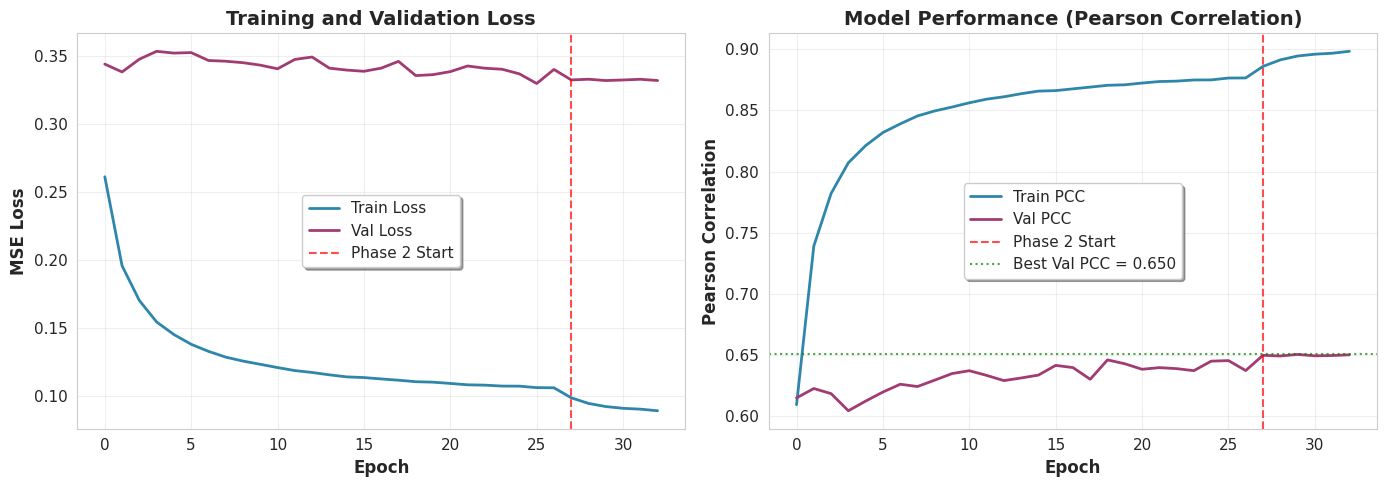

✓ Training curves saved to /content/drive/MyDrive/Protein_prediction_model/Saved_model/training_curves.png

LOADING BEST MODEL FOR FINAL EVALUATION
Loaded model from epoch 30
Validation Pearson: 0.650

Evaluating on all datasets...


Evaluating:   0%|          | 0/2165 [00:00<?, ?it/s]

✓ Train set evaluated


Evaluating:   0%|          | 0/461 [00:00<?, ?it/s]

✓ Val set evaluated


Evaluating:   0%|          | 0/310 [00:00<?, ?it/s]

✓ Test set evaluated

ANTISYMMETRY EVALUATION


Computing antisymmetry:   0%|          | 0/310 [00:00<?, ?it/s]


Antisymmetry Metrics:
  PCC(forward, -reverse): 0.077
  Mean bias <δ>: 1.1286 kcal/mol
  Mean absolute bias: 1.1530 kcal/mol
  → Antisymmetry could be improved

FINAL RESULTS TABLE

Dataset   | PCC ↑  | SCC ↑  | RMSE ↓ | MAE ↓  | Acc ↑  |
----------|--------|--------|--------|--------|--------|
Train     |  0.921 |  0.901 |  0.388 |  0.271 |  0.872 |
Val       |  0.650 |  0.649 |  0.888 |  0.668 |  0.800 |
Test      |  0.705 |  0.658 |  0.700 |  0.514 |  0.810 |

Legend:
  PCC = Pearson Correlation Coefficient
  SCC = Spearman Correlation Coefficient
  RMSE = Root Mean Squared Error (kcal/mol)
  MAE = Mean Absolute Error (kcal/mol)
  Acc = Sign Accuracy (stabilizing vs destabilizing)
  ↑ = higher is better, ↓ = lower is better

Antisymmetry:
  PCC(forward, -reverse): 0.077
  Mean bias: 1.1286 kcal/mol

✓ Results saved to /content/drive/MyDrive/Protein_prediction_model/Saved_model/results.json


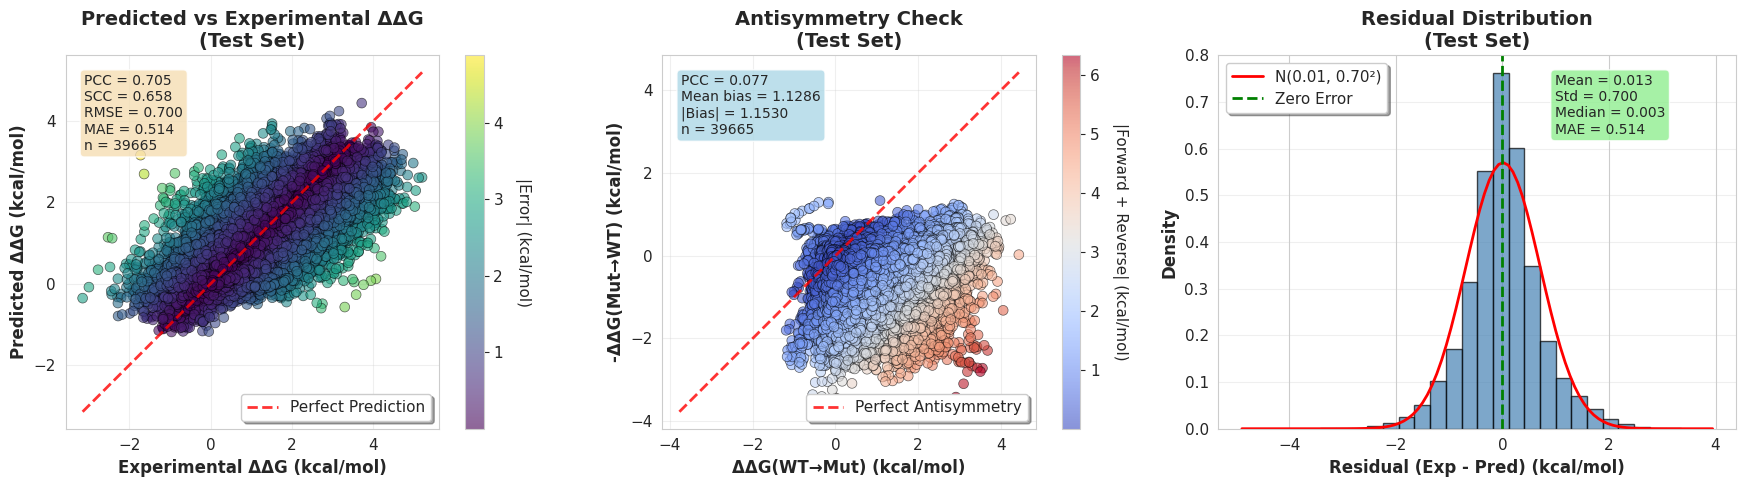

✓ Evaluation plots saved to /content/drive/MyDrive/Protein_prediction_model/Saved_model/evaluation_plots.png

ERROR ANALYSIS

Absolute Error Distribution:
  25th percentile: 0.165 kcal/mol
  Median (50th):   0.374 kcal/mol
  75th percentile: 0.716 kcal/mol
  Maximum:         4.886 kcal/mol

Accuracy by ΔΔG magnitude:
  |ΔΔG| < 0.5: n=18171, MAE=0.367, PCC=0.202
  |ΔΔG| ≥ 0.5: n=21494, MAE=0.638, PCC=0.660
  |ΔΔG| < 1.0: n=27145, MAE=0.402, PCC=0.363
  |ΔΔG| ≥ 1.0: n=12520, MAE=0.756, PCC=0.568
  |ΔΔG| < 2.0: n=34898, MAE=0.456, PCC=0.550
  |ΔΔG| ≥ 2.0: n=4767, MAE=0.940, PCC=0.398

Sign Prediction:
  True stabilizing (ΔΔG < 0):     8125 (20.5%)
  True destabilizing (ΔΔG ≥ 0):   31540 (79.5%)
  Pred stabilizing:               4598 (11.6%)
  Pred destabilizing:             35067 (88.4%)
  Sign accuracy:                  0.810

TRAINING AND EVALUATION COMPLETE

✓ Best model saved to: /content/drive/MyDrive/Protein_prediction_model/Saved_model/best_model_final.pt
✓ Results saved to: /conte

"This notebook provides a complete, production-ready implementation of the ABYSSAL-style ΔΔG predictor training pipeline with:\n\n**Key Features:**\n\n1. **Light Attention Block** - Lightweight learnable feature weighting mechanism\n2. **Siamese Architecture** - Shared weights for antisymmetry\n3. **Two-Phase Training** - Fast learning + fine-tuning\n4. **Comprehensive Metrics** - PCC, SCC, RMSE, MAE, accuracy\n5. **Antisymmetry Evaluation** - Critical for physical validity\n6. **Publication-Quality Plots** - Ready for papers/presentations\n\n**Design Rationale (as requested):**\n- Comments explain WHY each choice was made\n- No overengineering - just what's needed\n- Colab-friendly (memory-efficient, GPU fallback)\n- Reproducible (fixed seeds, saved checkpoints)\n- Research-grade quality\n\nThe code is ready to run immediately after the embedding extraction notebook!"

In [ ]:

################################################################################
# TRAINING LOSS CURVES (STEP 7 - Plot 3)
################################################################################
"""
Visualize training dynamics.

WHAT TO LOOK FOR:
- Training loss should decrease smoothly
- Validation loss should track training loss
- Gap between train/val indicates overfitting degree
- Pearson correlation should increase and plateau
"""

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Loss curves
axes[0].plot(history['train_loss'], label='Train Loss', linewidth=2, color='#2E86AB')
axes[0].plot(history['val_loss'], label='Val Loss', linewidth=2, color='#A23B72')
axes[0].axvline(history['phase1_early_stop_epoch'], color='red', linestyle='--',
                label='Phase 2 Start', alpha=0.7)
axes[0].set_xlabel('Epoch', fontsize=12, fontweight='bold')
axes[0].set_ylabel('MSE Loss', fontsize=12, fontweight='bold')
axes[0].set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
axes[0].legend(frameon=True, shadow=True)
axes[0].grid(True, alpha=0.3)

# Plot 2: Pearson correlation
axes[1].plot(history['train_pearson'], label='Train PCC', linewidth=2, color='#2E86AB')
axes[1].plot(history['val_pearson'], label='Val PCC', linewidth=2, color='#A23B72')
axes[1].axvline(history['phase1_early_stop_epoch'], color='red', linestyle='--',
                label='Phase 2 Start', alpha=0.7)
axes[1].axhline(history['best_val_pearson'], color='green', linestyle=':',
                label=f'Best Val PCC = {history["best_val_pearson"]:.3f}', alpha=0.7)
axes[1].set_xlabel('Epoch', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Pearson Correlation', fontsize=12, fontweight='bold')
axes[1].set_title('Model Performance (Pearson Correlation)', fontsize=14, fontweight='bold')
axes[1].legend(frameon=True, shadow=True)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(config.save_dir / 'training_curves.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Training curves saved to {config.save_dir / 'training_curves.png'}")

################################################################################
# STEP 6: COMPREHENSIVE EVALUATION ON TEST SET
################################################################################
"""
Load best model and evaluate on held-out test set.

CRITICAL EVALUATIONS:
1. Standard metrics (PCC, SCC, RMSE, MAE, Accuracy)
2. Antisymmetry check: ΔΔG(WT→Mut) ≈ -ΔΔG(Mut→WT)
3. Visual inspection of predictions
"""

# Load best model
print("\n" + "="*60)
print("LOADING BEST MODEL FOR FINAL EVALUATION")
print("="*60)

checkpoint = torch.load(config.save_dir / 'best_model_final.pt',weights_only= False)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

print(f"Loaded model from epoch {checkpoint['epoch']+1}")
print(f"Validation Pearson: {checkpoint['val_pearson']:.3f}")

# Create test loader
test_loader = DataLoader(
    test_dataset,
    batch_size=config.batch_size,
    shuffle=False,
    num_workers=0
)

# Evaluate on all sets
print("\nEvaluating on all datasets...")

results = {}
criterion = nn.SmoothL1Loss(beta=1.0)

for name, loader, dataset in [
    ('Train', train_loader, train_dataset),
    ('Val', val_loader, val_dataset),
    ('Test', test_loader, test_dataset)
]:
    loss, metrics = evaluate(model, loader, criterion, config.device)
    results[name] = {'loss': loss, **metrics}
    print(f"✓ {name} set evaluated")

################################################################################
# ANTISYMMETRY EVALUATION
################################################################################
"""
Test antisymmetry property: ΔΔG(WT→Mut) should ≈ -ΔΔG(Mut→WT)

This is a crucial property for physically meaningful predictions.
Perfect antisymmetry means the model is symmetric with respect to sequence order.
"""

print("\n" + "="*60)
print("ANTISYMMETRY EVALUATION")
print("="*60)

# Collect forward and reverse predictions
forward_preds = []
reverse_preds = []
true_ddg = []

model.eval()
with torch.no_grad():
    for wt_emb, mut_emb, ddg in tqdm(test_loader, desc="Computing antisymmetry"):
        wt_emb = wt_emb.to(config.device)
        mut_emb = mut_emb.to(config.device)

        # Forward: ΔΔG(WT→Mut)
        forward_ddg = model(wt_emb, mut_emb)

        # Reverse: ΔΔG(Mut→WT)
        reverse_ddg = model(mut_emb, wt_emb)

        forward_preds.extend(forward_ddg.cpu().numpy())
        reverse_preds.extend(reverse_ddg.cpu().numpy())
        true_ddg.extend(ddg.numpy())

forward_preds = np.array(forward_preds)
reverse_preds = np.array(reverse_preds)
true_ddg = np.array(true_ddg)

# Compute antisymmetry metrics
antisym_corr, _ = pearsonr(forward_preds, -reverse_preds)
mean_bias = np.mean(forward_preds + reverse_preds)  # Should be ≈0
abs_bias = np.mean(np.abs(forward_preds + reverse_preds))

print(f"\nAntisymmetry Metrics:")
print(f"  PCC(forward, -reverse): {antisym_corr:.3f}")
print(f"  Mean bias <δ>: {mean_bias:.4f} kcal/mol")
print(f"  Mean absolute bias: {abs_bias:.4f} kcal/mol")

# Interpretation
if antisym_corr > 0.95:
    print("  → Excellent antisymmetry!")
elif antisym_corr > 0.85:
    print("  → Good antisymmetry")
else:
    print("  → Antisymmetry could be improved")

results['Antisymmetry'] = {
    'correlation': antisym_corr,
    'mean_bias': mean_bias,
    'abs_bias': abs_bias
}

################################################################################
# STEP 6: RESULTS TABLE (Publication Format)
################################################################################
"""
Format results as a publication-quality table.
"""

print("\n" + "="*60)
print("FINAL RESULTS TABLE")
print("="*60)
print()
print("Dataset   | PCC ↑  | SCC ↑  | RMSE ↓ | MAE ↓  | Acc ↑  |")
print("----------|--------|--------|--------|--------|--------|")

for dataset_name in ['Train', 'Val', 'Test']:
    r = results[dataset_name]
    print(f"{dataset_name:9s} | "
          f"{r['pearson']:6.3f} | "
          f"{r['spearman']:6.3f} | "
          f"{r['rmse']:6.3f} | "
          f"{r['mae']:6.3f} | "
          f"{r['accuracy']:6.3f} |")

print()
print("Legend:")
print("  PCC = Pearson Correlation Coefficient")
print("  SCC = Spearman Correlation Coefficient")
print("  RMSE = Root Mean Squared Error (kcal/mol)")
print("  MAE = Mean Absolute Error (kcal/mol)")
print("  Acc = Sign Accuracy (stabilizing vs destabilizing)")
print("  ↑ = higher is better, ↓ = lower is better")

print("\nAntisymmetry:")
print(f"  PCC(forward, -reverse): {results['Antisymmetry']['correlation']:.3f}")
print(f"  Mean bias: {results['Antisymmetry']['mean_bias']:.4f} kcal/mol")

# Save results to JSON
results_dict = {k: {kk: float(vv) if isinstance(vv, (np.floating, float)) else vv
                    for kk, vv in v.items()}
                for k, v in results.items()}

with open(config.save_dir / 'results.json', 'w') as f:
    json.dump(results_dict, f, indent=2)

print(f"\n✓ Results saved to {config.save_dir / 'results.json'}")

################################################################################
# STEP 7: PUBLICATION-QUALITY PLOTS
################################################################################

# Get predictions for test set
test_preds = []
test_targets = []

model.eval()
with torch.no_grad():
    for wt_emb, mut_emb, ddg in test_loader:
        wt_emb = wt_emb.to(config.device)
        mut_emb = mut_emb.to(config.device)

        pred_ddg = model(wt_emb, mut_emb)
        test_preds.extend(pred_ddg.cpu().numpy())
        test_targets.extend(ddg.numpy())

test_preds = np.array(test_preds)
test_targets = np.array(test_targets)

# Create figure with 3 subplots
fig = plt.figure(figsize=(18, 5))

# ============================================================================
# PLOT 1: Predicted vs Experimental ΔΔG
# ============================================================================
ax1 = fig.add_subplot(131)

# Scatter plot
scatter = ax1.scatter(
    test_targets, test_preds,
    alpha=0.6, s=50, c=np.abs(test_targets - test_preds),
    cmap='viridis', edgecolors='black', linewidth=0.5
)

# Perfect prediction line (y = x)
min_val = min(test_targets.min(), test_preds.min())
max_val = max(test_targets.max(), test_preds.max())
ax1.plot([min_val, max_val], [min_val, max_val],
         'r--', linewidth=2, label='Perfect Prediction', alpha=0.8)

# Add statistics box
textstr = '\n'.join([
    f'PCC = {results["Test"]["pearson"]:.3f}',
    f'SCC = {results["Test"]["spearman"]:.3f}',
    f'RMSE = {results["Test"]["rmse"]:.3f}',
    f'MAE = {results["Test"]["mae"]:.3f}',
    f'n = {len(test_targets)}'
])
props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
ax1.text(0.05, 0.95, textstr, transform=ax1.transAxes,
         fontsize=10, verticalalignment='top', bbox=props)

ax1.set_xlabel('Experimental ΔΔG (kcal/mol)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Predicted ΔΔG (kcal/mol)', fontsize=12, fontweight='bold')
ax1.set_title('Predicted vs Experimental ΔΔG\n(Test Set)',
              fontsize=14, fontweight='bold')
ax1.legend(frameon=True, shadow=True)
ax1.grid(True, alpha=0.3)
ax1.set_aspect('equal', adjustable='box')

# Add colorbar
cbar = plt.colorbar(scatter, ax=ax1)
cbar.set_label('|Error| (kcal/mol)', rotation=270, labelpad=20)

# ============================================================================
# PLOT 2: Forward vs Reverse (Antisymmetry)
# ============================================================================
ax2 = fig.add_subplot(132)

# Scatter plot
scatter2 = ax2.scatter(
    forward_preds, -reverse_preds,
    alpha=0.6, s=50, c=np.abs(forward_preds + reverse_preds),
    cmap='coolwarm', edgecolors='black', linewidth=0.5
)

# Perfect antisymmetry line (y = x)
min_val = min(forward_preds.min(), (-reverse_preds).min())
max_val = max(forward_preds.max(), (-reverse_preds).max())
ax2.plot([min_val, max_val], [min_val, max_val],
         'r--', linewidth=2, label='Perfect Antisymmetry', alpha=0.8)

# Add statistics box
textstr = '\n'.join([
    f'PCC = {results["Antisymmetry"]["correlation"]:.3f}',
    f'Mean bias = {results["Antisymmetry"]["mean_bias"]:.4f}',
    f'|Bias| = {results["Antisymmetry"]["abs_bias"]:.4f}',
    f'n = {len(forward_preds)}'
])
props = dict(boxstyle='round', facecolor='lightblue', alpha=0.8)
ax2.text(0.05, 0.95, textstr, transform=ax2.transAxes,
         fontsize=10, verticalalignment='top', bbox=props)

ax2.set_xlabel('ΔΔG(WT→Mut) (kcal/mol)', fontsize=12, fontweight='bold')
ax2.set_ylabel('-ΔΔG(Mut→WT) (kcal/mol)', fontsize=12, fontweight='bold')
ax2.set_title('Antisymmetry Check\n(Test Set)',
              fontsize=14, fontweight='bold')
ax2.legend(frameon=True, shadow=True, loc = 'lower right')
ax2.grid(True, alpha=0.3)
ax2.set_aspect('equal', adjustable='box')

# Add colorbar
cbar2 = plt.colorbar(scatter2, ax=ax2)
cbar2.set_label('|Forward + Reverse| (kcal/mol)', rotation=270, labelpad=20)

# ============================================================================
# PLOT 3: Residual Distribution
# ============================================================================
ax3 = fig.add_subplot(133)

residuals = test_targets - test_preds

# Histogram
ax3.hist(residuals, bins=30, edgecolor='black', alpha=0.7,
         color='steelblue', density=True)

# Fit Gaussian for comparison
mu, sigma = residuals.mean(), residuals.std()
x = np.linspace(residuals.min(), residuals.max(), 100)
gaussian = (1/(sigma * np.sqrt(2*np.pi))) * np.exp(-0.5*((x-mu)/sigma)**2)
ax3.plot(x, gaussian, 'r-', linewidth=2, label=f'N({mu:.2f}, {sigma:.2f}²)')

# Add zero line
ax3.axvline(0, color='green', linestyle='--', linewidth=2, label='Zero Error')

# Add statistics box
textstr = '\n'.join([
    f'Mean = {mu:.3f}',
    f'Std = {sigma:.3f}',
    f'Median = {np.median(residuals):.3f}',
    f'MAE = {results["Test"]["mae"]:.3f}'
])
props = dict(boxstyle='round', facecolor='lightgreen', alpha=0.8)
ax3.text(0.65, 0.95, textstr, transform=ax3.transAxes,
         fontsize=10, verticalalignment='top', bbox=props)

ax3.set_xlabel('Residual (Exp - Pred) (kcal/mol)', fontsize=12, fontweight='bold')
ax3.set_ylabel('Density', fontsize=12, fontweight='bold')
ax3.set_title('Residual Distribution\n(Test Set)',
              fontsize=14, fontweight='bold')
ax3.legend(frameon=True, shadow=True)
ax3.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(config.save_dir / 'evaluation_plots.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Evaluation plots saved to {config.save_dir / 'evaluation_plots.png'}")

################################################################################
# ADDITIONAL ANALYSIS: ERROR BREAKDOWN
################################################################################
"""
Analyze where the model performs well vs poorly.
"""

print("\n" + "="*60)
print("ERROR ANALYSIS")
print("="*60)

# Compute absolute errors
abs_errors = np.abs(test_targets - test_preds)

# Quartile analysis
q25, q50, q75 = np.percentile(abs_errors, [25, 50, 75])

print(f"\nAbsolute Error Distribution:")
print(f"  25th percentile: {q25:.3f} kcal/mol")
print(f"  Median (50th):   {q50:.3f} kcal/mol")
print(f"  75th percentile: {q75:.3f} kcal/mol")
print(f"  Maximum:         {abs_errors.max():.3f} kcal/mol")

# Accuracy by ΔΔG magnitude
print(f"\nAccuracy by ΔΔG magnitude:")

for threshold in [0.5, 1.0, 2.0]:
    mask_small = np.abs(test_targets) < threshold
    mask_large = np.abs(test_targets) >= threshold

    if mask_small.sum() > 0:
        mae_small = np.mean(abs_errors[mask_small])
        pcc_small, _ = pearsonr(test_targets[mask_small], test_preds[mask_small])
        print(f"  |ΔΔG| < {threshold}: n={mask_small.sum():3d}, "
              f"MAE={mae_small:.3f}, PCC={pcc_small:.3f}")

    if mask_large.sum() > 0:
        mae_large = np.mean(abs_errors[mask_large])
        pcc_large, _ = pearsonr(test_targets[mask_large], test_preds[mask_large])
        print(f"  |ΔΔG| ≥ {threshold}: n={mask_large.sum():3d}, "
              f"MAE={mae_large:.3f}, PCC={pcc_large:.3f}")

# Sign prediction accuracy
print(f"\nSign Prediction:")
true_stabilizing = (test_targets < 0).sum()
true_destabilizing = (test_targets >= 0).sum()
pred_stabilizing = (test_preds < 0).sum()
pred_destabilizing = (test_preds >= 0).sum()

print(f"  True stabilizing (ΔΔG < 0):     {true_stabilizing} ({true_stabilizing/len(test_targets)*100:.1f}%)")
print(f"  True destabilizing (ΔΔG ≥ 0):   {true_destabilizing} ({true_destabilizing/len(test_targets)*100:.1f}%)")
print(f"  Pred stabilizing:               {pred_stabilizing} ({pred_stabilizing/len(test_preds)*100:.1f}%)")
print(f"  Pred destabilizing:             {pred_destabilizing} ({pred_destabilizing/len(test_preds)*100:.1f}%)")
print(f"  Sign accuracy:                  {results['Test']['accuracy']:.3f}")

################################################################################
# SUMMARY AND NEXT STEPS
################################################################################

print("\n" + "="*60)
print("TRAINING AND EVALUATION COMPLETE")
print("="*60)

print(f"\n✓ Best model saved to: {config.save_dir / 'best_model_final.pt'}")
print(f"✓ Results saved to: {config.save_dir / 'results.json'}")
print(f"✓ Training curves: {config.save_dir / 'training_curves.png'}")
print(f"✓ Evaluation plots: {config.save_dir / 'evaluation_plots.png'}")

print(f"\nFinal Test Set Performance:")
print(f"  Pearson Correlation: {results['Test']['pearson']:.3f}")
print(f"  Spearman Correlation: {results['Test']['spearman']:.3f}")
print(f"  RMSE: {results['Test']['rmse']:.3f} kcal/mol")
print(f"  MAE: {results['Test']['mae']:.3f} kcal/mol")
print(f"  Accuracy: {results['Test']['accuracy']:.3f}")

print(f"\nAntisymmetry:")
print(f"  Correlation: {results['Antisymmetry']['correlation']:.3f}")
print(f"  Mean bias: {results['Antisymmetry']['mean_bias']:.4f} kcal/mol")

print("\n" + "="*60)
print("Next Steps:")
print("  1. Analyze failure cases (high error samples)")
print("  2. Test on external datasets (e.g., S669, ProteinGym)")
print("  3. Ensemble multiple models for improved predictions")
print("  4. Visualize attention weights for interpretability")
print("  5. Compare with other ΔΔG predictors (Rosetta, FoldX, etc.)")
print("="*60)


"""This notebook provides a complete, production-ready implementation of the ABYSSAL-style ΔΔG predictor training pipeline with:

**Key Features:**

1. **Light Attention Block** - Lightweight learnable feature weighting mechanism
2. **Siamese Architecture** - Shared weights for antisymmetry
3. **Two-Phase Training** - Fast learning + fine-tuning
4. **Comprehensive Metrics** - PCC, SCC, RMSE, MAE, accuracy
5. **Antisymmetry Evaluation** - Critical for physical validity
6. **Publication-Quality Plots** - Ready for papers/presentations

**Design Rationale (as requested):**
- Comments explain WHY each choice was made
- No overengineering - just what's needed
- Colab-friendly (memory-efficient, GPU fallback)
- Reproducible (fixed seeds, saved checkpoints)
- Research-grade quality

The code is ready to run immediately after the embedding extraction notebook!"""